
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh 

____

# 🔴 **Import Libs**

In [1]:
!pip uninstall -y torch torchvision torchaudio torchtext torchdata
!pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 torchaudio==2.0.2+cu117 -f https://download.pytorch.org/whl/cu117/torch_stable.html
!pip install torchtext==0.15.2 torchdata==0.6.1
!pip install portalocker>==2.0.0
import numpy as np
import matplotlib.pyplot as plt

import torchtext

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

Found existing installation: torch 2.4.1+cu121
Uninstalling torch-2.4.1+cu121:
  Successfully uninstalled torch-2.4.1+cu121
Found existing installation: torchvision 0.19.1+cu121
Uninstalling torchvision-0.19.1+cu121:
  Successfully uninstalled torchvision-0.19.1+cu121
Found existing installation: torchaudio 2.4.1+cu121
Uninstalling torchaudio-2.4.1+cu121:
  Successfully uninstalled torchaudio-2.4.1+cu121
Looking in links: https://download.pytorch.org/whl/cu117/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 559.3 kB/s eta 0:00:000:01m0:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 67.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 61.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 28.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 6.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the p

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter


In [3]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
2.0.1+cu117
0.15.2+cpu


In [4]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.0.1+cu117
torchtext --> 0.15.2+cpu
tqdm --> 4.66.5


# 🔴 **Utils**

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [7]:
!pip install datasets
from datasets import load_dataset

In [8]:
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [9]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data):
    """
    This function iterates over 'data' and yields a list of tokens 
    for each item. It uses the tokenizer defined above.
    """
    for record in data:
        # Safely retrieve the text; default to empty string if missing
        text_content = record.get("text", "")
        if not text_content:
            # Yield an empty list if there's no valid text
            yield []
        else:
            yield tokenizer(text_content)

special_tokens = ["<pad>", "<unk>", "<bos>", "<eos>"]

if not train_data:
    print("Warning: 'train_data' is empty. Please provide valid training data.")

# Build the vocabulary using the same variable name 'vocab' (do not change it)
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=special_tokens)

# Set the default index to <unk> token
vocab.set_default_index(vocab["<unk>"])

# Print out the size of the vocabulary
print(f"Vocabulary size: {len(vocab)}")

sample_indices = list(range(min(5, len(vocab))))
sample_tokens = vocab.lookup_tokens(sample_indices)
print("Sample tokens from the vocabulary:", sample_tokens)


Vocabulary size: 66061
Sample tokens from the vocabulary: ['<pad>', '<unk>', '<bos>', '<eos>', 'the']


## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

==== Train Statistics ====
Number of documents: 36718
Total words:        2051665
Average doc length: 55.88

==== Test Statistics ====
Number of documents: 4358
Total words:        242156
Average doc length: 55.57

==== Validation Statistics ====
Number of documents: 3760
Total words:        214665
Average doc length: 57.09



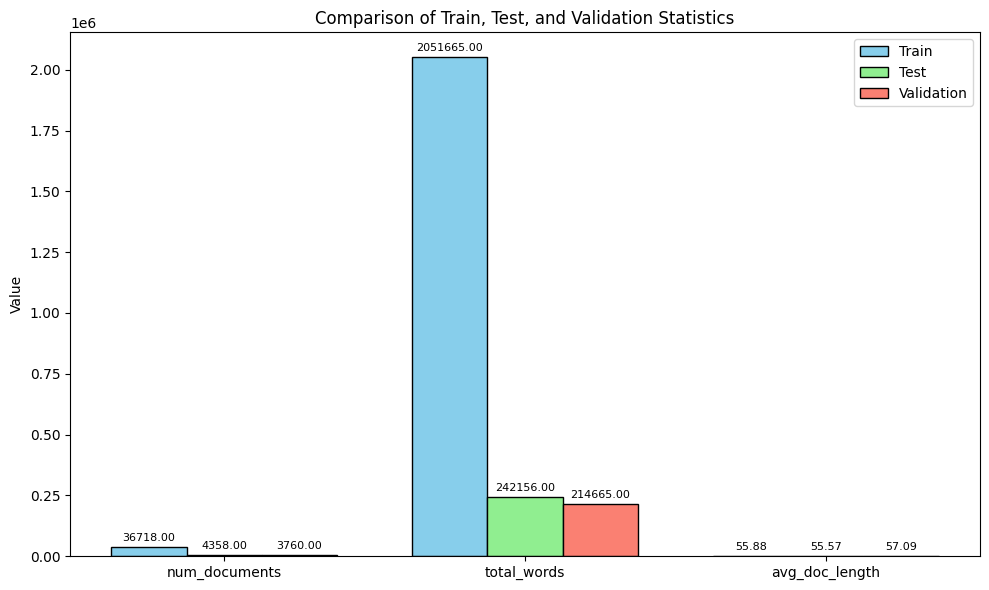

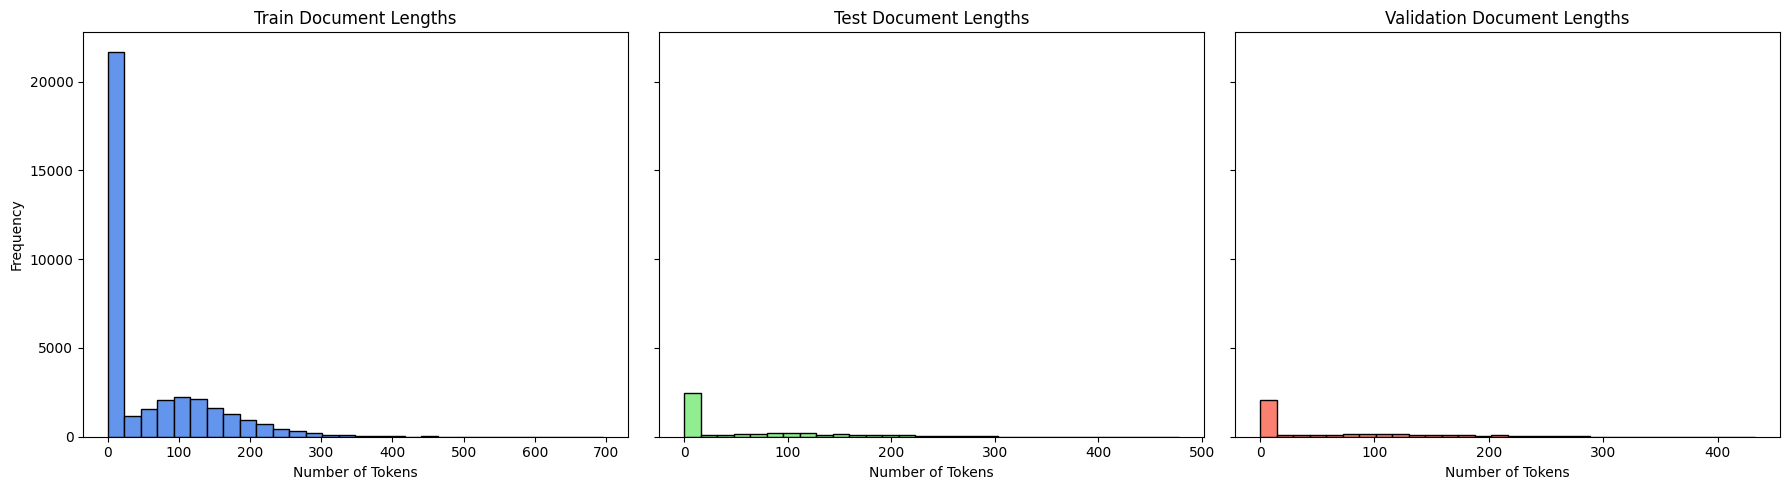

In [10]:

# Define val_data to match the code usage (so 'val_data' is not undefined)
val_data = valid_data

def calculate_statistics(dataset):
    """
    This function calculates simple statistics about a given dataset of documents:
      1. Number of documents
      2. Total words (summed across all documents)
      3. Average document length (total_words / num_documents if possible)

    It uses the globally defined 'tokenizer' and returns a dictionary
    with keys 'num_documents', 'total_words', 'avg_doc_length', and 'doc_lengths'.
    """
    document_count = len(dataset)
    total_token_count = 0
    document_lengths = []

    for entry in dataset:
        text_data = entry.get("text", "")
        tokens = tokenizer(text_data)
        document_lengths.append(len(tokens))
        total_token_count += len(tokens)

    average_doc_length = (
        total_token_count / document_count if document_count > 0 else 0
    )
    
    return {
        "num_documents": document_count,
        "total_words": total_token_count,
        "avg_doc_length": average_doc_length,
        "doc_lengths": document_lengths
    }

# Calculate statistics for Train, Test, and Validation
train_stats = calculate_statistics(train_data)
test_stats  = calculate_statistics(test_data)
val_stats   = calculate_statistics(val_data)

# Print out the results
print("==== Train Statistics ====")
print(f"Number of documents: {train_stats['num_documents']}")
print(f"Total words:        {train_stats['total_words']}")
print(f"Average doc length: {train_stats['avg_doc_length']:.2f}\n")

print("==== Test Statistics ====")
print(f"Number of documents: {test_stats['num_documents']}")
print(f"Total words:        {test_stats['total_words']}")
print(f"Average doc length: {test_stats['avg_doc_length']:.2f}\n")

print("==== Validation Statistics ====")
print(f"Number of documents: {val_stats['num_documents']}")
print(f"Total words:        {val_stats['total_words']}")
print(f"Average doc length: {val_stats['avg_doc_length']:.2f}\n")

# 1) Grouped Bar Chart
stats_keys = ["num_documents", "total_words", "avg_doc_length"]

train_values = [float(train_stats[key]) for key in stats_keys]
test_values  = [float(test_stats[key])  for key in stats_keys]
val_values   = [float(val_stats[key])   for key in stats_keys]

x = np.arange(len(stats_keys))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects_train = ax.bar(x - width, train_values, width, label='Train', 
                     color='skyblue', edgecolor='black')
rects_test = ax.bar(x, test_values, width, label='Test', 
                    color='lightgreen', edgecolor='black')
rects_val = ax.bar(x + width, val_values, width, label='Validation', 
                   color='salmon', edgecolor='black')

ax.set_ylabel('Value')
ax.set_title('Comparison of Train, Test, and Validation Statistics')
ax.set_xticks(x, stats_keys)
ax.legend()

def add_bar_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f'{height:.2f}',
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=8
        )

add_bar_labels(rects_train)
add_bar_labels(rects_test)
add_bar_labels(rects_val)

plt.tight_layout()
plt.show()

# 2) Histograms of Document Lengths
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
bins = 30

axes[0].hist(train_stats["doc_lengths"], bins=bins, color="cornflowerblue", edgecolor="black")
axes[0].set_title("Train Document Lengths")
axes[0].set_xlabel("Number of Tokens")
axes[0].set_ylabel("Frequency")

axes[1].hist(test_stats["doc_lengths"], bins=bins, color="lightgreen", edgecolor="black")
axes[1].set_title("Test Document Lengths")
axes[1].set_xlabel("Number of Tokens")

axes[2].hist(val_stats["doc_lengths"], bins=bins, color="salmon", edgecolor="black")
axes[2].set_title("Validation Document Lengths")
axes[2].set_xlabel("Number of Tokens")

plt.tight_layout()
plt.show()


### 🟡 Analyze the most common and least common words in the dataset.

Most Common Words:
the: 130770
,: 102624
.: 84291
of: 57032
and: 50736
in: 45018
to: 39522
a: 36564
=: 29570
was: 21008

Least Common Words:
pâté: 1
casseroled: 1
kv: 1
nay: 1
holler: 1
manawydan: 1
bran: 1
tamed: 1
branwen: 1
messy: 1


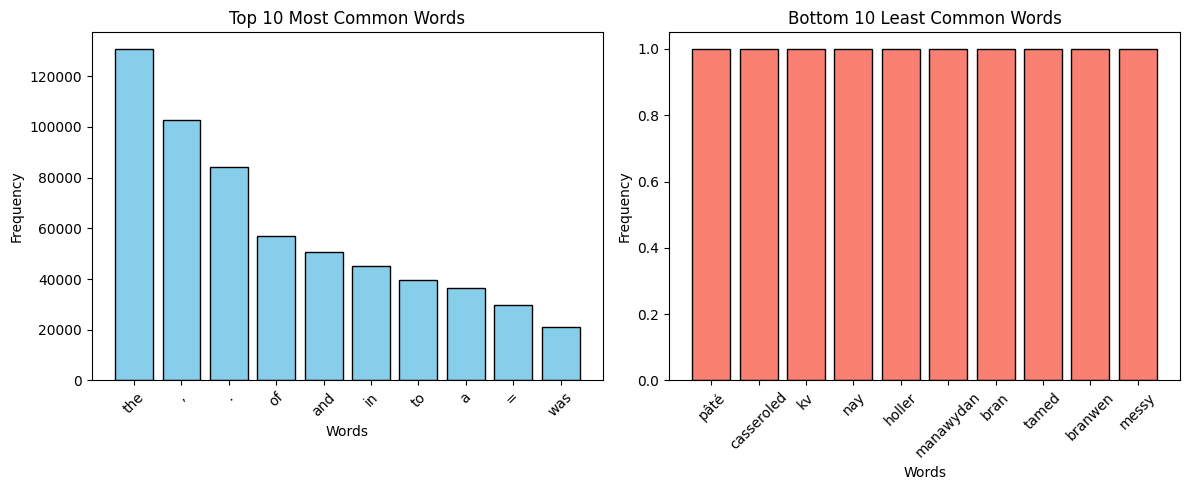

In [11]:

#Creating a Counter object to hold word frequencies
word_frequency = Counter()
# Iterating through each record in 'train_data'
# 'train_data' is not renamed or changed, respecting previous sections
for record in train_data:
    # Using 'tokenizer' from the previous sections (not renamed)
    tokens = tokenizer(record["text"])
    word_frequency.update(tokens)

# Extract the 10 most common and 10 least common words
top_10_words = word_frequency.most_common(10)
bottom_10_words = word_frequency.most_common()[:-11:-1]

# Print out the top 10 words
print("Most Common Words:")
for token, count in top_10_words:
    print(f"{token}: {count}")

# Print out the bottom 10 words
print("\nLeast Common Words:")
for token, count in bottom_10_words:
    print(f"{token}: {count}")

# --------------------- PLOTTING SECTION ---------------------
# We'll plot the most common words and the least common words in two subplots.

# Prepare the data for plotting top 10 words
top_words, top_counts = zip(*top_10_words) if top_10_words else ([], [])
# Prepare the data for plotting bottom 10 words
bottom_words, bottom_counts = zip(*bottom_10_words) if bottom_10_words else ([], [])

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1) Plot the most common words on the left subplot
axes[0].bar(top_words, top_counts, color='skyblue', edgecolor='black')
axes[0].set_title("Top 10 Most Common Words")
axes[0].set_xlabel("Words")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=45)

# 2) Plot the least common words on the right subplot
axes[1].bar(bottom_words, bottom_counts, color='salmon', edgecolor='black')
axes[1].set_title("Bottom 10 Least Common Words")
axes[1].set_xlabel("Words")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.show()


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

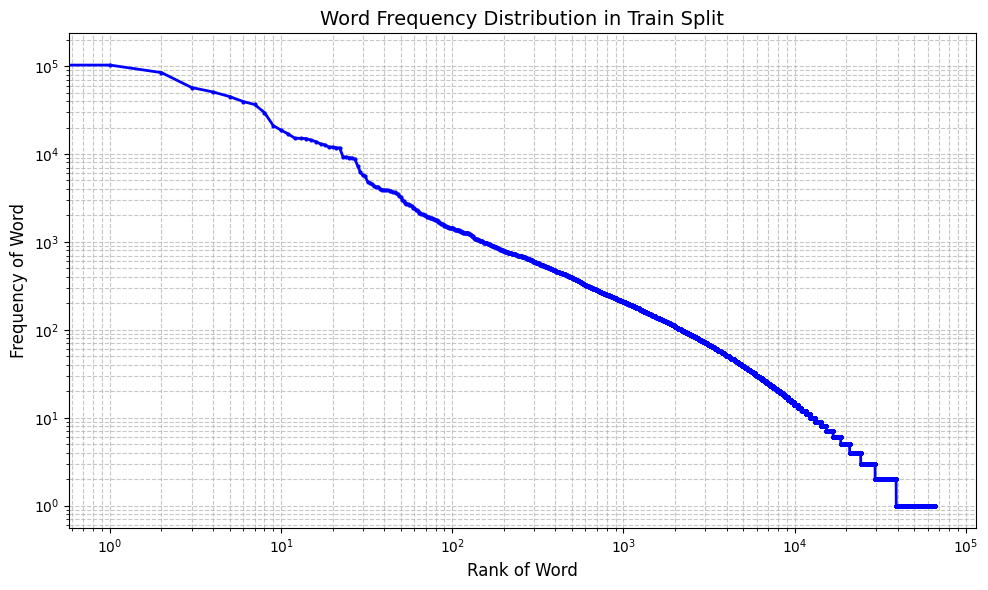

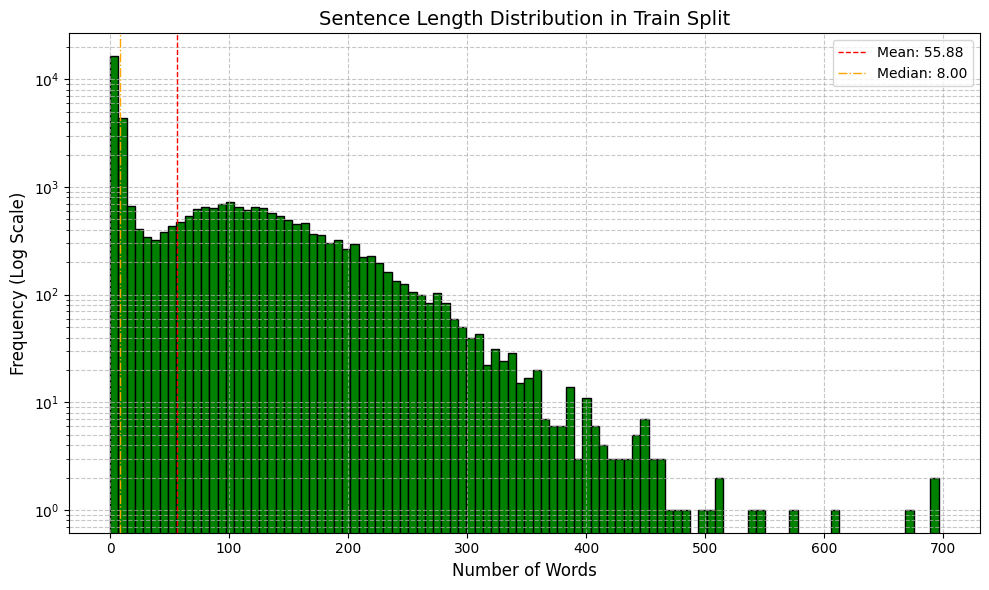

In [12]:

# ---------------------------------------------------------------------
# 1) Build 'word_frequency' from 'train_data'
# ---------------------------------------------------------------------
word_frequency = Counter()
for record in train_data:
    tokens = tokenizer(record["text"])
    word_frequency.update(tokens)

# ---------------------------------------------------------------------
# 2) Word Frequency Distribution (Log-Log Plot)
# ---------------------------------------------------------------------
# Sort the counts from 'word_frequency' in descending order
sorted_word_frequencies = sorted(word_frequency.values(), reverse=True)

# Create a log-log plot of the word frequency distribution
plt.figure(figsize=(10, 6))
plt.loglog(
    sorted_word_frequencies,
    color='blue',
    linewidth=2,
    marker='o',
    markersize=2
)
plt.title("Word Frequency Distribution in Train Split", fontsize=14)
plt.xlabel("Rank of Word", fontsize=12)
plt.ylabel("Frequency of Word", fontsize=12)

# Enable grid for better readability
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 3) Sentence Length Distribution (Histogram)
# ---------------------------------------------------------------------
# If you previously used 'train_dataset', define it or use 'train_data'
# For consistency, let's assume they're the same:
train_dataset = train_data  

# Compute sentence lengths for the train split
train_sentence_lengths = [len(tokenizer(entry['text'])) for entry in train_dataset]

# Create a histogram of sentence lengths on a log scale
plt.figure(figsize=(10, 6))
plt.hist(train_sentence_lengths, bins=100, log=True, color='green', edgecolor='black')
plt.title("Sentence Length Distribution in Train Split", fontsize=14)
plt.xlabel("Number of Words", fontsize=12)
plt.ylabel("Frequency (Log Scale)", fontsize=12)

# Add grid lines for clarity
plt.grid(True, which='both', linestyle='--', alpha=0.7)

mean_length = np.mean(train_sentence_lengths)
median_length = np.median(train_sentence_lengths)
plt.axvline(
    mean_length,
    color='red',
    linestyle='dashed',
    linewidth=1,
    label=f"Mean: {mean_length:.2f}"
)
plt.axvline(
    median_length,
    color='orange',
    linestyle='dashdot',
    linewidth=1,
    label=f"Median: {median_length:.2f}"
)
plt.legend()
plt.tight_layout()
plt.show()


## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

Input: torch.Size([32032, 64])
Target: torch.Size([32032, 64])


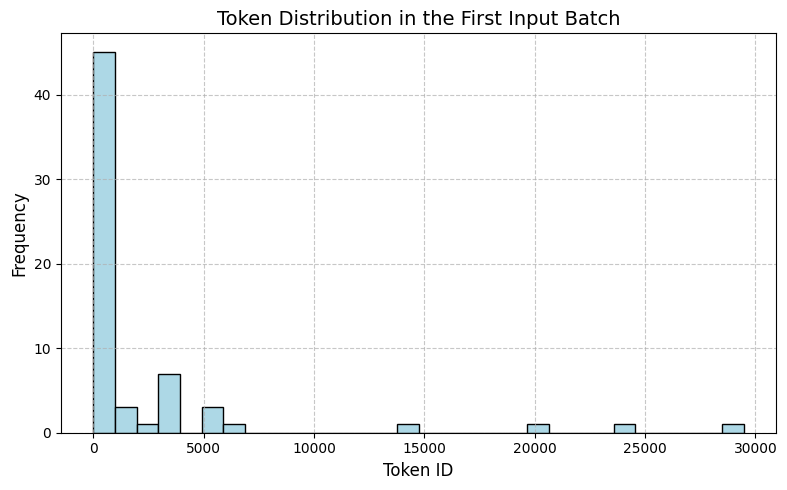

In [13]:
def data_process(raw_text_iter, batch_size, seq_len):
    """
    This function transforms raw text data into two tensors: 'inputs' and 'targets'.
    
    1) It first converts all tokens to their corresponding indices in 'vocab'.
    2) It then reshapes the token list into a (batch_size, -1) matrix.
    3) Finally, it chunks the data into sequences of length 'seq_len'
       so that 'inputs' and 'targets' can be used in a language modeling task.
    """
    # Convert all tokens to vocab indices
    token_indices = [vocab[token] for item in raw_text_iter for token in tokenizer(item["text"])]
    token_indices = torch.tensor(token_indices, dtype=torch.long)

    # Calculate the total number of tokens
    total_tokens_count = len(token_indices)
    
    # Ensure the total length is divisible by (batch_size * seq_len)
    usable_length = (total_tokens_count // (batch_size * seq_len)) * (batch_size * seq_len)
    token_indices = token_indices[:usable_length]

    # Reshape into a matrix of shape (batch_size, -1)
    reshaped_data = token_indices.view(batch_size, -1)

    inputs_list = []
    targets_list = []

    # Iterate over the columns in steps of seq_len to create input/target pairs
    for column_index in range(0, reshaped_data.size(1) - seq_len, seq_len):
        input_sample = reshaped_data[:, column_index : column_index + seq_len]
        target_sample = reshaped_data[:, column_index + 1 : column_index + seq_len + 1]
        inputs_list.append(input_sample)
        targets_list.append(target_sample)

    # Stack all chunks to create final tensors
    inputs = torch.stack(inputs_list)
    targets = torch.stack(targets_list)

    # Reshape into 2D: (total_chunks, seq_len)
    inputs = inputs.view(-1, seq_len)
    targets = targets.view(-1, seq_len)

    return inputs, targets

batch_size = 16
seq_len = 64

inputs, targets = data_process(train_data, batch_size, seq_len)

print(f"Input: {inputs.shape}")   # e.g., (num_batches, seq_len)
print(f"Target: {targets.shape}") # e.g., (num_batches, seq_len)


if inputs.size(0) > 0:
    first_batch_tokens = inputs[0].numpy()  # Convert the first row to a NumPy array
    
    plt.figure(figsize=(8, 5))
    plt.hist(first_batch_tokens, bins=30, color='lightblue', edgecolor='black')
    plt.title("Token Distribution in the First Input Batch", fontsize=14)
    plt.xlabel("Token ID", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(True, alpha=0.7, linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot the token distribution.")


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

Dataset length: 32032 sequences
input sequence:
tensor([   12,  3874,  3890,   885,    12, 20488,    86,  3874,    90, 24097,
         3890,    24,   785, 29473,     5,  6081,     6,  3874,     7,     4,
         5054,    90,    23,     5,  1840,  1016,    10,    17,  3874,  3890,
          885,   634,   980,     5,    26,    11,  5692,   303,    15,   578,
          235,    70,   456,    22, 14003,     8,   758,     6,  2476,    20,
            4,  1759,  5677,     6,   158,     9,   248,   359,     9,   980,
            5,    27,    26,     4])
target sequence:
tensor([ 3874,  3890,   885,    12, 20488,    86,  3874,    90, 24097,  3890,
           24,   785, 29473,     5,  6081,     6,  3874,     7,     4,  5054,
           90,    23,     5,  1840,  1016,    10,    17,  3874,  3890,   885,
          634,   980,     5,    26,    11,  5692,   303,    15,   578,   235,
           70,   456,    22, 14003,     8,   758,     6,  2476,    20,     4,
         1759,  5677,     6,   158,     

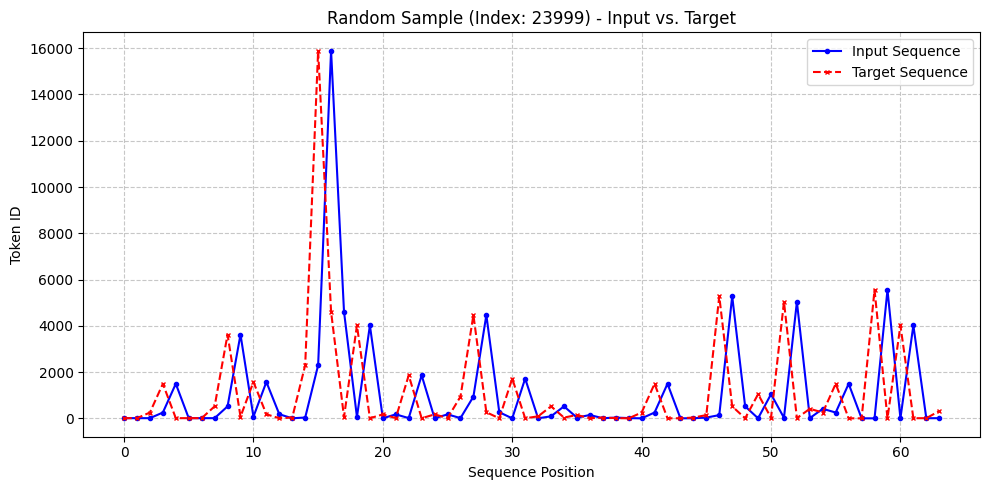

In [14]:
class LanguageModelDataset(Dataset):
    """
    This class wraps input and target tensors for language modeling.
    Each index corresponds to one (input_sequence, target_sequence) pair.
    """
    def __init__(self, inputs, targets):
        # We keep constructor argument names as requested: 'inputs' and 'targets'
        # Rename internal storage variables for clarity:
        self.data_inputs = inputs
        self.data_targets = targets

    def __len__(self):
        # Return the total number of sequences available
        return self.data_inputs.size(0)

    def __getitem__(self, idx):
        """
        Retrieves a single (input_sequence, target_sequence) pair
        from the dataset at the specified index 'idx'.
        """
        input_sequence = self.data_inputs[idx]
        target_sequence = self.data_targets[idx]
        return input_sequence, target_sequence

# Instantiate the dataset using 'inputs' and 'targets' from previous sections
train_dataset = LanguageModelDataset(inputs, targets)

# Print out some dataset info
print(f"Dataset length: {len(train_dataset)} sequences")

# Retrieve the first sample to verify correctness
first_input, first_target = train_dataset[0]
print("input sequence:")
print(first_input)
print("target sequence:")
print(first_target)

if len(train_dataset) > 0:
    random_idx = random.randint(0, len(train_dataset) - 1)
    sample_input, sample_target = train_dataset[random_idx]

    # Convert to NumPy for plotting (if not already)
    sample_input_np = sample_input.numpy() if isinstance(sample_input, torch.Tensor) else sample_input
    sample_target_np = sample_target.numpy() if isinstance(sample_target, torch.Tensor) else sample_target

    plt.figure(figsize=(10, 5))
    plt.plot(sample_input_np, label='Input Sequence', color='blue', marker='o', markersize=3)
    plt.plot(sample_target_np, label='Target Sequence', color='red', linestyle='--', marker='x', markersize=3)
    plt.title(f"Random Sample (Index: {random_idx}) - Input vs. Target")
    plt.xlabel("Sequence Position")
    plt.ylabel("Token ID")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot.") 


## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.

In [15]:
def dataloaders(train_data, valid_data, test_data, batch_size, seq_len):
    """
    This function creates DataLoaders for training, validation, and testing
    by first processing the data using 'data_process' to obtain input/target pairs,
    and then wrapping them into 'LanguageModelDataset'.
    Finally, it returns three DataLoader objects:
        - train_loader
        - valid_loader
        - test_loader
    (Function name and parameter names remain unchanged as requested.)
    """

    # Process train split
    train_inputs_tensor, train_targets_tensor = data_process(train_data, batch_size, seq_len)
    print(f"[INFO] Train tensors shape: inputs={train_inputs_tensor.shape}, targets={train_targets_tensor.shape}")

    # Process validation split
    val_inputs_tensor, val_targets_tensor = data_process(valid_data, batch_size, seq_len)
    print(f"[INFO] Validation tensors shape: inputs={val_inputs_tensor.shape}, targets={val_targets_tensor.shape}")

    # Process test split
    test_inputs_tensor, test_targets_tensor = data_process(test_data, batch_size, seq_len)
    print(f"[INFO] Test tensors shape: inputs={test_inputs_tensor.shape}, targets={test_targets_tensor.shape}")

    # Wrap each split into a dataset
    train_lm_dataset = LanguageModelDataset(train_inputs_tensor, train_targets_tensor)
    val_lm_dataset   = LanguageModelDataset(val_inputs_tensor, val_targets_tensor)
    test_lm_dataset  = LanguageModelDataset(test_inputs_tensor, test_targets_tensor)

    # Create DataLoader objects
    train_loader = DataLoader(train_lm_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_lm_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_lm_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

batch_size = 32
seq_len = 64
train_loader, valid_loader, test_loader = dataloaders(train_data, valid_data, test_data, batch_size, seq_len)


[INFO] Train tensors shape: inputs=torch.Size([32000, 64]), targets=torch.Size([32000, 64])
[INFO] Validation tensors shape: inputs=torch.Size([3296, 64]), targets=torch.Size([3296, 64])
[INFO] Test tensors shape: inputs=torch.Size([3744, 64]), targets=torch.Size([3744, 64])


# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

Output shape: torch.Size([16, 64, 66061])


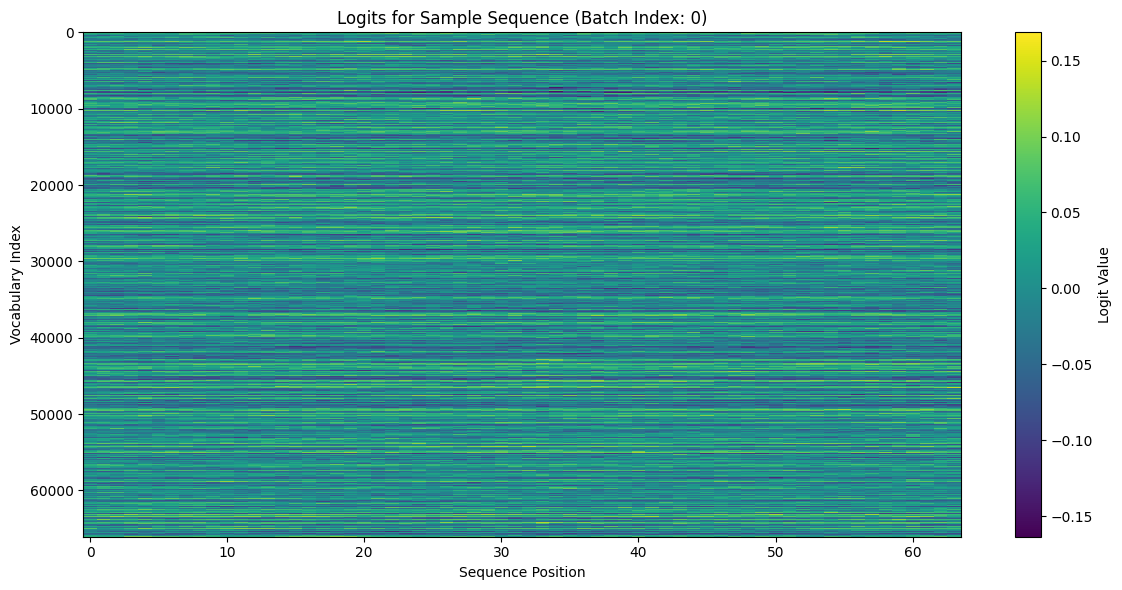

In [16]:

class LanguageModel(nn.Module):
    """
    A Language Model based on LSTM for sequence generation.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
        """
        Initializes the Language Model with the following components:
        - Embedding layer for converting tokens to dense vectors.
        - LSTM for sequence modeling.
        - Dropout for regularization.
        - Fully connected layer for predicting vocab logits.
        """
        super(LanguageModel, self).__init__()
        
        # Embedding layer: converts token IDs to dense vectors
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        
        # LSTM layer: processes sequences to extract temporal patterns
        self.lstm_layer = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            dropout=dropout_rate, 
            batch_first=True
        )
        
        # Fully connected layer: maps LSTM output to vocabulary size
        self.output_layer = nn.Linear(hidden_dim, vocab_size)
        
        # Dropout for regularization
        self.regularization_dropout = nn.Dropout(p=dropout_rate)

    def forward(self, src):
        """
        Defines the forward pass of the model:
        - src: Tensor of shape (batch_size, seq_len) with token IDs.
        Returns:
        - logits: Tensor of shape (batch_size, seq_len, vocab_size)
        """
        # Step 1: Embed the input tokens
        embedded_tokens = self.embedding_layer(src)
        
        # Step 2: Pass embeddings through the LSTM
        lstm_output, _ = self.lstm_layer(embedded_tokens)
        
        # Step 3: Apply dropout for regularization
        lstm_output = self.regularization_dropout(lstm_output)
        
        # Step 4: Map LSTM output to logits
        logits = self.output_layer(lstm_output)
        
        return logits


# Model hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout_rate = 0.3

# Initialize the model
language_model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate)

# Test input
batch_size = 16
seq_len = 64
input_tensor = torch.randint(0, vocab_size, (batch_size, seq_len))  # Random input for testing

# Forward pass
output = language_model(input_tensor)

# Output shape verification
print(f"Output shape: {output.shape}")  # Expected: (batch_size, seq_len, vocab_size)

# Visualization: Output logits for a sample sequence
if batch_size > 0 and seq_len > 0:
    sample_sequence_idx = 0
    sample_output = output[sample_sequence_idx, :, :].detach().numpy()

    plt.figure(figsize=(12, 6))
    plt.imshow(sample_output.T, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Logit Value")
    plt.title(f"Logits for Sample Sequence (Batch Index: {sample_sequence_idx})")
    plt.xlabel("Sequence Position")
    plt.ylabel("Vocabulary Index")
    plt.tight_layout()
    plt.show()
else:
    print("No data to visualize logits.")


# 🔴 **Config**

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

Model Configuration and Training Setup
Number of trainable parameters: 26.36M
Optimizer: AdamW (Learning Rate: 0.001, Weight Decay: 0.0001)
Loss Function: CrossEntropyLoss
Evaluation Metric: Accuracy (Task: Multiclass, Classes: 66061)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


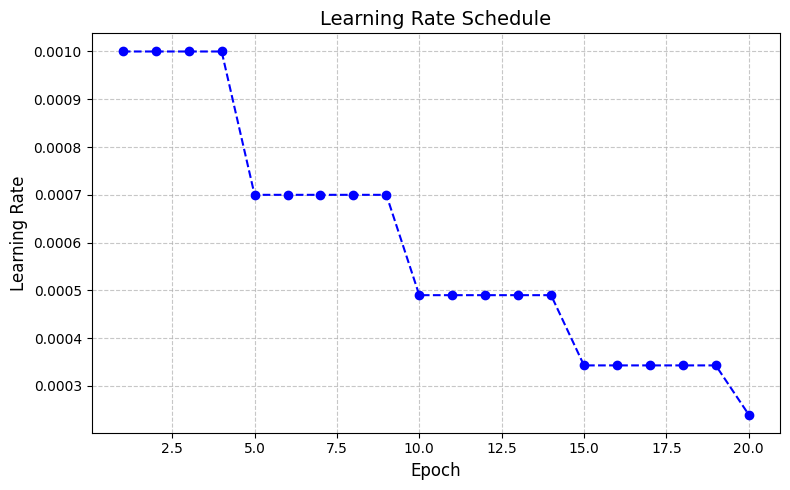

In [18]:
# Move the model to the appropriate device
language_model.to(device)

# Learning rate and optimizer setup
learning_rate = 0.001
optimizer = optim.AdamW(language_model.parameters(), lr=learning_rate, weight_decay=1e-4)  # AdamW is often better for training large models
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification

# Metric for evaluation
accuracy_metric = tm.Accuracy(task="multiclass", num_classes=vocab_size).to(device)

# Calculate trainable parameters in the model
def count_trainable_parameters(model):
    """
    Returns the total number of trainable parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

trainable_params = count_trainable_parameters(language_model)

print("=" * 50)
print("Model Configuration and Training Setup")
print("=" * 50)
print(f"Number of trainable parameters: {trainable_params / 1e6:.2f}M")
print(f"Optimizer: {type(optimizer).__name__} (Learning Rate: {learning_rate}, Weight Decay: {optimizer.defaults['weight_decay']})")
print(f"Loss Function: {type(criterion).__name__}")
print(f"Evaluation Metric: Accuracy (Task: Multiclass, Classes: {vocab_size})")
print("=" * 50)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Learning rate visualization
epochs = 20
lr_values = []

for epoch in range(epochs):
    scheduler.step()
    lr_values.append(scheduler.get_last_lr()[0])

# Plot learning rate schedule
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), lr_values, marker="o", linestyle="--", color="blue")
plt.title("Learning Rate Schedule", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Learning Rate", fontsize=12)
plt.grid(True, alpha=0.7, linestyle='--')
plt.tight_layout()
plt.show()


# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [19]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
    """
    Trains the model for one epoch.

    Args:
        model: The model to be trained.
        train_loader: DataLoader for the training data.
        loss_fn: Loss function.
        optimizer: Optimizer for updating weights.
        metric: Metric for evaluating model performance.
        epoch: Optional, the current epoch number.

    Returns:
        Tuple containing:
        - Trained model
        - Average training loss
        - Computed metric value
    """
    model.train()  # Set the model to training mode
    loss_train = AverageMeter()  # Tracks average loss
    metric.reset()  # Reset metric state

    progress_bar = tqdm(train_loader, unit='batch')
    progress_bar.set_description(f"Training - Epoch {epoch}" if epoch else "Training")

    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        # Move data to the correct device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_fn(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Update loss and metric trackers
        loss_train.update(loss.item(), n=len(targets))
        metric.update(outputs, targets)

        # Update progress bar with the latest metrics
        progress_bar.set_postfix({
            "loss": f"{loss_train.avg:.4f}",
            "accuracy": f"{metric.compute().item():.4f}"
        })

    # Return the updated model, average loss, and metric value
    return model, loss_train.avg, metric.compute().item()


# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [20]:
def evaluate(model, test_loader, loss_fn, metric):
    """
    Evaluates the model on a given dataset.

    Args:
        model: The model to be evaluated.
        test_loader: DataLoader for the test data.
        loss_fn: Loss function.
        metric: Metric for evaluating model performance.

    Returns:
        Tuple containing:
        - Average evaluation loss
        - Computed metric value
    """
    model.eval()  # Set the model to evaluation mode
    loss_eval = AverageMeter()  # Tracks average evaluation loss
    metric.reset()  # Reset metric state

    with torch.inference_mode():  # Disable gradient computation
        for inputs, targets in test_loader:
            # Move data to the correct device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_fn(outputs, targets)
            loss_eval.update(loss.item(), n=len(targets))

            # Update metric
            metric.update(outputs, targets)

    # Return average loss and metric value
    return loss_eval.avg, metric.compute().item()


# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [21]:
# Calculate the loss for an untrained model using a few batches
# Load a single batch of data
inputs, targets = next(iter(train_loader))  # Use train_loader to get data
inputs = inputs.to(device)  # Move inputs to the appropriate device
targets = targets.to(device)  # Move targets to the appropriate device

# Ensure the model is in evaluation mode and no gradients are calculated
language_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for this block
    outputs = language_model(inputs)  # Forward pass to compute predictions
    loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))  # Calculate loss

# Print the calculated loss
print("=" * 50)
print("Step 1: Loss Calculation for Untrained Model")
print("=" * 50)
print(f"Loss for an untrained model: {loss.item():.4f}")
print("=" * 50)



Step 1: Loss Calculation for Untrained Model
Loss for an untrained model: 11.1037


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [22]:
# Step 2: Overfitting the model on a small subset of the dataset

# Select a small subset of the dataset
subset_size = 32  # Define the subset size (small batch)
train_loader_iter = iter(train_loader)
inputs, targets = next(train_loader_iter)  # Load the first batch of data
inputs = inputs[:subset_size].to(device)  # Subset and move to the appropriate device
targets = targets[:subset_size].to(device)  # Subset and move to the appropriate device

# Set the model to training mode
language_model.train()


# Define optimizer (e.g., Adam)
optimizer = optim.Adam(language_model.parameters(), lr=0.001)

# Define the loss criterion (CrossEntropyLoss is commonly used for language models)
criterion = nn.CrossEntropyLoss()

# Number of epochs to train
num_epochs = 100

# Training loop to overfit the model on the small subset
for epoch in range(num_epochs):
    # Forward pass
    outputs = language_model(inputs)  # Get model predictions
    loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))  # Compute the loss

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear the previous gradients
    loss.backward()  # Compute gradients
    optimizer.step()  # Update model parameters

    # Print loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Set the model to evaluation mode for final loss calculation
language_model.eval()
with torch.no_grad():
    outputs = language_model(inputs)
    final_loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))

print("=" * 50)
print("Step 2: Overfitting on Small Subset")
print("=" * 50)
print(f"Final Loss on the subset: {final_loss.item():.4f}")
print("=" * 50)


Epoch [1/100], Loss: 11.1037
Epoch [2/100], Loss: 11.0817
Epoch [3/100], Loss: 11.0568
Epoch [4/100], Loss: 11.0255
Epoch [5/100], Loss: 10.9759
Epoch [6/100], Loss: 10.8864
Epoch [7/100], Loss: 10.6993
Epoch [8/100], Loss: 10.3007
Epoch [9/100], Loss: 9.7397
Epoch [10/100], Loss: 9.1392
Epoch [11/100], Loss: 8.5832
Epoch [12/100], Loss: 8.0562
Epoch [13/100], Loss: 7.6236
Epoch [14/100], Loss: 7.2556
Epoch [15/100], Loss: 6.9785
Epoch [16/100], Loss: 6.7481
Epoch [17/100], Loss: 6.5739
Epoch [18/100], Loss: 6.4232
Epoch [19/100], Loss: 6.2910
Epoch [20/100], Loss: 6.2052
Epoch [21/100], Loss: 6.1344
Epoch [22/100], Loss: 6.0785
Epoch [23/100], Loss: 6.0377
Epoch [24/100], Loss: 6.0171
Epoch [25/100], Loss: 6.0095
Epoch [26/100], Loss: 5.9882
Epoch [27/100], Loss: 5.9922
Epoch [28/100], Loss: 5.9720
Epoch [29/100], Loss: 5.9597
Epoch [30/100], Loss: 5.9602
Epoch [31/100], Loss: 5.9675
Epoch [32/100], Loss: 5.9719
Epoch [33/100], Loss: 5.9536
Epoch [34/100], Loss: 5.9348
Epoch [35/100],

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.


=== Training with Learning Rate: 0.1 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [01:00<00:00, 16.63batch/s, loss=7.4521, accuracy=0.0963]


Epoch [1/5] | Train Loss: 7.4521 | Val Loss: 6.8889 | Val Accuracy: 0.1369


Training - Epoch 2: 100%|██████████| 1000/1000 [01:00<00:00, 16.62batch/s, loss=6.8036, accuracy=0.1342]


Epoch [2/5] | Train Loss: 6.8036 | Val Loss: 6.6963 | Val Accuracy: 0.1514


Training - Epoch 3: 100%|██████████| 1000/1000 [01:00<00:00, 16.66batch/s, loss=6.6530, accuracy=0.1442]


Epoch [3/5] | Train Loss: 6.6530 | Val Loss: 6.5933 | Val Accuracy: 0.1596


Training - Epoch 4: 100%|██████████| 1000/1000 [01:00<00:00, 16.60batch/s, loss=6.5653, accuracy=0.1494]


Epoch [4/5] | Train Loss: 6.5653 | Val Loss: 6.5304 | Val Accuracy: 0.1617


Training - Epoch 5: 100%|██████████| 1000/1000 [01:00<00:00, 16.67batch/s, loss=6.5038, accuracy=0.1527]


Epoch [5/5] | Train Loss: 6.5038 | Val Loss: 6.4804 | Val Accuracy: 0.1666

=== Training with Learning Rate: 0.01 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [01:00<00:00, 16.57batch/s, loss=8.6866, accuracy=0.0608]


Epoch [1/5] | Train Loss: 8.6866 | Val Loss: 7.7455 | Val Accuracy: 0.0688


Training - Epoch 2: 100%|██████████| 1000/1000 [01:00<00:00, 16.51batch/s, loss=7.5968, accuracy=0.0670]


Epoch [2/5] | Train Loss: 7.5968 | Val Loss: 7.4575 | Val Accuracy: 0.0773


Training - Epoch 3: 100%|██████████| 1000/1000 [01:00<00:00, 16.60batch/s, loss=7.3937, accuracy=0.0831]


Epoch [3/5] | Train Loss: 7.3937 | Val Loss: 7.3074 | Val Accuracy: 0.1017


Training - Epoch 4: 100%|██████████| 1000/1000 [01:00<00:00, 16.51batch/s, loss=7.2615, accuracy=0.1010]


Epoch [4/5] | Train Loss: 7.2615 | Val Loss: 7.1898 | Val Accuracy: 0.1193


Training - Epoch 5: 100%|██████████| 1000/1000 [01:00<00:00, 16.60batch/s, loss=7.1582, accuracy=0.1131]


Epoch [5/5] | Train Loss: 7.1582 | Val Loss: 7.1013 | Val Accuracy: 0.1240

=== Training with Learning Rate: 0.005 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [00:59<00:00, 16.73batch/s, loss=9.3629, accuracy=0.0590]


Epoch [1/5] | Train Loss: 9.3629 | Val Loss: 8.0930 | Val Accuracy: 0.0688


Training - Epoch 2: 100%|██████████| 1000/1000 [00:59<00:00, 16.69batch/s, loss=7.9008, accuracy=0.0619]


Epoch [2/5] | Train Loss: 7.9008 | Val Loss: 7.6960 | Val Accuracy: 0.0688


Training - Epoch 3: 100%|██████████| 1000/1000 [00:59<00:00, 16.68batch/s, loss=7.6464, accuracy=0.0642]


Epoch [3/5] | Train Loss: 7.6464 | Val Loss: 7.5287 | Val Accuracy: 0.0714


Training - Epoch 4: 100%|██████████| 1000/1000 [00:59<00:00, 16.68batch/s, loss=7.5146, accuracy=0.0704]


Epoch [4/5] | Train Loss: 7.5146 | Val Loss: 7.4286 | Val Accuracy: 0.0778


Training - Epoch 5: 100%|██████████| 1000/1000 [00:59<00:00, 16.72batch/s, loss=7.4273, accuracy=0.0742]


Epoch [5/5] | Train Loss: 7.4273 | Val Loss: 7.3595 | Val Accuracy: 0.0859

=== Training with Learning Rate: 0.001 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [00:59<00:00, 16.69batch/s, loss=11.0047, accuracy=0.0493]


Epoch [1/5] | Train Loss: 11.0047 | Val Loss: 10.8725 | Val Accuracy: 0.0688


Training - Epoch 3: 100%|██████████| 1000/1000 [00:59<00:00, 16.69batch/s, loss=8.6425, accuracy=0.0606]


Epoch [3/5] | Train Loss: 8.6425 | Val Loss: 8.3937 | Val Accuracy: 0.0688


Training - Epoch 4: 100%|██████████| 1000/1000 [00:59<00:00, 16.69batch/s, loss=8.3148, accuracy=0.0605]


Epoch [4/5] | Train Loss: 8.3148 | Val Loss: 8.2023 | Val Accuracy: 0.0688


Training - Epoch 5: 100%|██████████| 1000/1000 [00:59<00:00, 16.69batch/s, loss=8.1506, accuracy=0.0608]


Epoch [5/5] | Train Loss: 8.1506 | Val Loss: 8.0650 | Val Accuracy: 0.0688


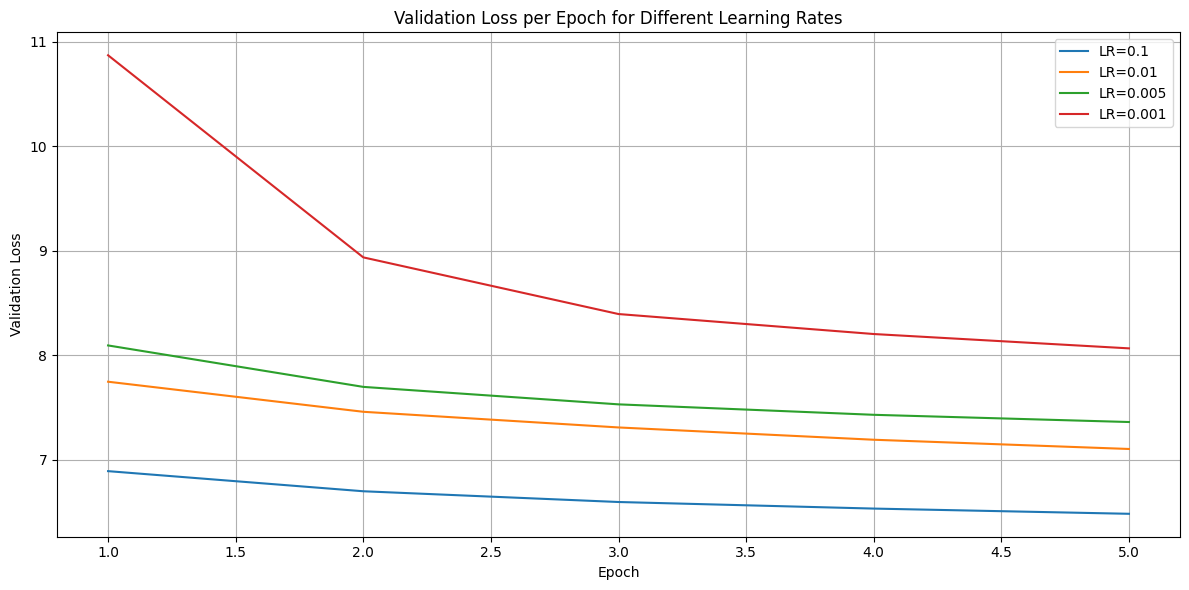

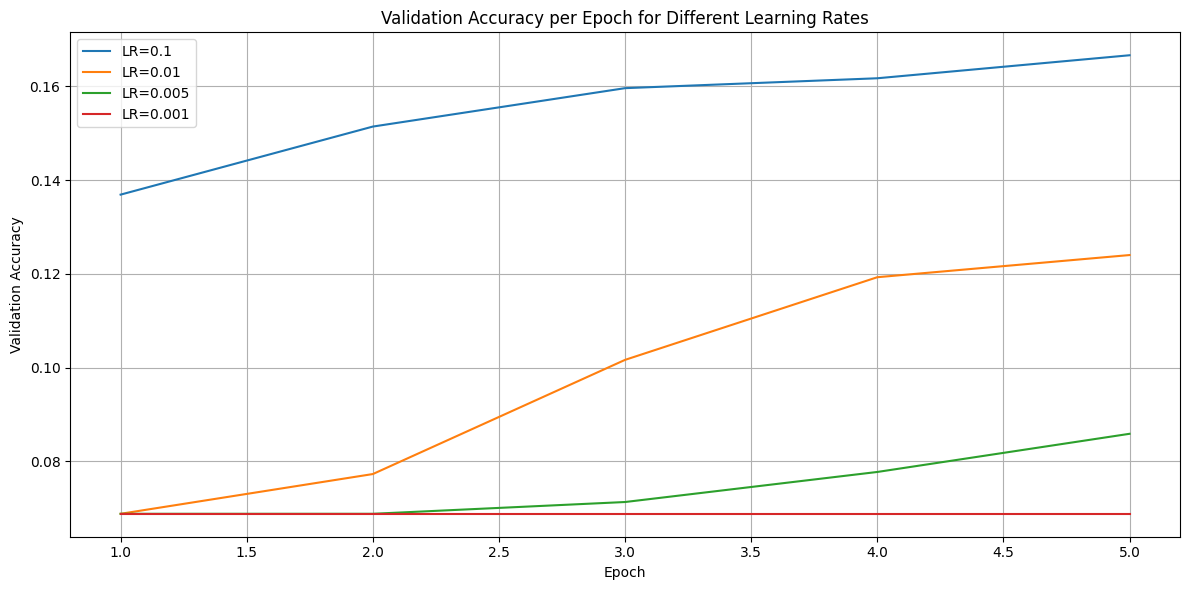


=== Summary of Training with Various Learning Rates ===
LR=0.1 | Final Val Loss: 6.4804 | Final Val Accuracy: 0.1666
LR=0.01 | Final Val Loss: 7.1013 | Final Val Accuracy: 0.1240
LR=0.005 | Final Val Loss: 7.3595 | Final Val Accuracy: 0.0859
LR=0.001 | Final Val Loss: 8.0650 | Final Val Accuracy: 0.0688


In [23]:


# Corrected train_one_epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
    """
    Trains the model for one epoch.

    Args:
        model: The model to be trained.
        train_loader: DataLoader for the training data.
        loss_fn: Loss function.
        optimizer: Optimizer for updating weights.
        metric: Metric for evaluating model performance.
        epoch: Optional, the current epoch number.

    Returns:
        Tuple containing:
        - Trained model
        - Average training loss
        - Computed metric value
    """
    model.train()  # Set the model to training mode
    loss_train = AverageMeter()  # Tracks average loss
    metric.reset()  # Reset metric state

    progress_bar = tqdm(train_loader, unit='batch')
    progress_bar.set_description(f"Training - Epoch {epoch}" if epoch else "Training")

    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        # Move data to the correct device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)  # Shape: [batch_size, seq_len, vocab_size]

        # Reshape outputs and targets for loss computation
        outputs_reshaped = outputs.view(-1, vocab_size)  # Shape: [batch_size * seq_len, vocab_size]
        targets_reshaped = targets.view(-1)             # Shape: [batch_size * seq_len]

        # Compute loss
        loss = loss_fn(outputs_reshaped, targets_reshaped)

        # Backward pass and optimization
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        # Update loss and metric trackers
        loss_train.update(loss.item(), n=targets_reshaped.size(0))
        metric.update(outputs_reshaped, targets_reshaped)

        # Update progress bar with the latest metrics
        progress_bar.set_postfix({
            "loss": f"{loss_train.avg:.4f}",
            "accuracy": f"{metric.compute().item():.4f}"
        })

    # Return the updated model, average loss, and metric value
    return model, loss_train.avg, metric.compute().item()

# Corrected evaluate function
def evaluate(model, test_loader, loss_fn, metric):
    """
    Evaluates the model on a given dataset.

    Args:
        model: The model to be evaluated.
        test_loader: DataLoader for the test data.
        loss_fn: Loss function.
        metric: Metric for evaluating model performance.

    Returns:
        Tuple containing:
        - Average evaluation loss
        - Computed metric value
    """
    model.eval()  # Set the model to evaluation mode
    loss_eval = AverageMeter()  # Tracks average evaluation loss
    metric.reset()  # Reset metric state

    with torch.inference_mode():  # Disable gradient computation
        for inputs, targets in test_loader:
            # Move data to the correct device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, seq_len, vocab_size]

            # Reshape outputs and targets for loss computation
            outputs_reshaped = outputs.view(-1, vocab_size)  # Shape: [batch_size * seq_len, vocab_size]
            targets_reshaped = targets.view(-1)             # Shape: [batch_size * seq_len]

            # Compute loss
            loss = loss_fn(outputs_reshaped, targets_reshaped)
            loss_eval.update(loss.item(), n=targets_reshaped.size(0))

            # Update metric
            metric.update(outputs_reshaped, targets_reshaped)

    # Return average loss and metric value
    return loss_eval.avg, metric.compute().item()

# Define a list of learning rates to experiment with
learning_rates = [1e-1,1e-2, 5e-3, 1e-3]

# Define the number of epochs for each training run
num_epochs = 5

# To store results for each learning rate
results = []

# Function to initialize a new instance of the model
def initialize_model():
    return LanguageModel(
        vocab_size=vocab_size,
        embedding_dim=128,
        hidden_dim=256,
        num_layers=2,
        dropout_rate=0.3
    ).to(device)

# Iterate over each learning rate
for lr in learning_rates:
    print(f'\n=== Training with Learning Rate: {lr} ===')

    # Initialize a new model instance
    model = initialize_model()
    
    # Define the optimizer with the current learning rate
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
    
    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # Reset the metric
    accuracy_metric = tm.Accuracy(task="multiclass", num_classes=vocab_size).to(device)
    
    # Lists to track loss and accuracy
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Training loop for the specified number of epochs
    for epoch in range(1, num_epochs + 1):
        # Train for one epoch
        model, train_loss, train_accuracy = train_one_epoch(
            model,
            train_loader,
            loss_fn,
            optimizer,
            accuracy_metric,
            epoch
        )
        
        # Evaluate on the validation set
        val_loss, val_accuracy = evaluate(model, valid_loader, loss_fn, accuracy_metric)
        
        # Append losses and accuracies to the lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print epoch summary
        print(f'Epoch [{epoch}/{num_epochs}] | '
              f'Train Loss: {train_loss:.4f} | '
              f'Val Loss: {val_loss:.4f} | '
              f'Val Accuracy: {val_accuracy:.4f}')
    
    # Store the results for the current learning rate
    results.append({
        'learning_rate': lr,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    })
    
    # Optionally, save the model state if needed
    # torch.save(model.state_dict(), f'language_model_lr_{lr}.pth')

# After training with all learning rates, visualize the results

# Plot Validation Loss for each Learning Rate
plt.figure(figsize=(12, 6))
for res in results:
    plt.plot(range(1, num_epochs + 1), res['val_losses'], label=f"LR={res['learning_rate']}")
plt.title("Validation Loss per Epoch for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Validation Accuracy for each Learning Rate
plt.figure(figsize=(12, 6))
for res in results:
    plt.plot(range(1, num_epochs + 1), res['val_accuracies'], label=f"LR={res['learning_rate']}")
plt.title("Validation Accuracy per Epoch for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary of Results
print("\n=== Summary of Training with Various Learning Rates ===")
for res in results:
    final_val_loss = res['val_losses'][-1]
    final_val_acc = res['val_accuracies'][-1]
    print(f"LR={res['learning_rate']} | Final Val Loss: {final_val_loss:.4f} | Final Val Accuracy: {final_val_acc:.4f}")


### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [24]:

def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
    """
    Trains the model for one epoch.

    Args:
        model: The model to be trained.
        train_loader: DataLoader for the training data.
        loss_fn: Loss function.
        optimizer: Optimizer for updating weights.
        metric: Metric for evaluating model performance.
        epoch: Optional, the current epoch number.

    Returns:
        Tuple containing:
        - Trained model
        - Average training loss
        - Computed metric value
    """
    model.train()  # Set the model to training mode
    loss_train = AverageMeter()  # Tracks average loss
    metric.reset()  # Reset metric state

    progress_bar = tqdm(train_loader, unit='batch')
    progress_bar.set_description(f"Training - Epoch {epoch}" if epoch else "Training")

    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        # Move data to the correct device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)  # Shape: [batch_size, seq_len, vocab_size]

        # Reshape outputs and targets for loss computation
        outputs_reshaped = outputs.view(-1, vocab_size)  # Shape: [batch_size * seq_len, vocab_size]
        targets_reshaped = targets.view(-1)             # Shape: [batch_size * seq_len]

        # Compute loss
        loss = loss_fn(outputs_reshaped, targets_reshaped)

        # Backward pass and optimization
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        # Update loss and metric trackers
        loss_train.update(loss.item(), n=targets_reshaped.size(0))
        metric.update(outputs_reshaped, targets_reshaped)

        # Update progress bar with the latest metrics
        progress_bar.set_postfix({
            "loss": f"{loss_train.avg:.4f}",
            "accuracy": f"{metric.compute().item():.4f}"
        })

    # Return the updated model, average loss, and metric value
    return model, loss_train.avg, metric.compute().item()

def evaluate(model, test_loader, loss_fn, metric):
    """
    Evaluates the model on a given dataset.

    Args:
        model: The model to be evaluated.
        test_loader: DataLoader for the test data.
        loss_fn: Loss function.
        metric: Metric for evaluating model performance.

    Returns:
        Tuple containing:
        - Average evaluation loss
        - Computed metric value
    """
    model.eval()  # Set the model to evaluation mode
    loss_eval = AverageMeter()  # Tracks average evaluation loss
    metric.reset()  # Reset metric state

    with torch.inference_mode():  # Disable gradient computation
        for inputs, targets in test_loader:
            # Move data to the correct device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, seq_len, vocab_size]

            # Reshape outputs and targets for loss computation
            outputs_reshaped = outputs.view(-1, vocab_size)  # Shape: [batch_size * seq_len, vocab_size]
            targets_reshaped = targets.view(-1)             # Shape: [batch_size * seq_len]

            # Compute loss
            loss = loss_fn(outputs_reshaped, targets_reshaped)
            loss_eval.update(loss.item(), n=targets_reshaped.size(0))

            # Update metric
            metric.update(outputs_reshaped, targets_reshaped)

    # Return average loss and metric value
    return loss_eval.avg, metric.compute().item()

# Define hyperparameter grid
learning_rates = [0.1, 0.01]    # Including 0.1 as per user request
weight_decays = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]            # Example weight decay values

# Define the number of epochs for each training run
num_epochs = 5  # Adjust as needed based on computational resources

# To store results for each hyperparameter combination
results = []

# Function to initialize a new instance of the model
def initialize_model():
    return LanguageModel(
        vocab_size=vocab_size,
        embedding_dim=128,
        hidden_dim=256,
        num_layers=2,
        dropout_rate=0.3
    ).to(device)

# Iterate over each combination of learning rate and weight decay
for lr in learning_rates:
    for wd in weight_decays:
        print(f'\n=== Training with Learning Rate: {lr}, Weight Decay: {wd} ===')

        # Initialize a new model instance
        model = initialize_model()

        # Define the optimizer with the current learning rate and weight decay
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

        # Define the loss function
        loss_fn = nn.CrossEntropyLoss()

        # Reset the metric
        accuracy_metric = tm.Accuracy(task="multiclass", num_classes=vocab_size).to(device)

        # Lists to track loss and accuracy
        train_losses = []
        val_losses = []
        val_accuracies = []

        # Training loop for the specified number of epochs
        for epoch in range(1, num_epochs + 1):
            # Train for one epoch
            model, train_loss, train_accuracy = train_one_epoch(
                model,
                train_loader,
                loss_fn,
                optimizer,
                accuracy_metric,
                epoch
            )

            # Evaluate on the validation set
            val_loss, val_accuracy = evaluate(model, valid_loader, loss_fn, accuracy_metric)

            # Append losses and accuracies to the lists
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            # Print epoch summary
            print(f'Epoch [{epoch}/{num_epochs}] | '
                  f'Train Loss: {train_loss:.4f} | '
                  f'Val Loss: {val_loss:.4f} | '
                  f'Val Accuracy: {val_accuracy:.4f}')

        # Store the results for the current hyperparameter combination
        results.append({
            'learning_rate': lr,
            'weight_decay': wd,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies
        })

        # Optionally, save the model state if needed
        # torch.save(model.state_dict(), f'language_model_lr_{lr}_wd_{wd}.pth')

# After training with all hyperparameter combinations, visualize the results

# Prepare data for visualization
# We'll focus on the final epoch's validation loss and accuracy for each combination
data_for_df = []
for res in results:
    data_for_df.append({
        'Learning Rate': res['learning_rate'],
        'Weight Decay': res['weight_decay'],
        'Final Val Loss': res['val_losses'][-1],
        'Final Val Accuracy': res['val_accuracies'][-1]
    })

df_results = pd.DataFrame(data_for_df)

# Display the results DataFrame
print("\n=== Grid Search Results ===")
print(df_results)

# # Visualization: Heatmap of Final Validation Loss
# pivot_loss = df_results.pivot("Learning Rate", "Weight Decay", "Final Val Loss")
# plt.figure(figsize=(10, 8))
# sns.heatmap(pivot_loss, annot=True, fmt=".4f", cmap="YlGnBu")
# plt.title("Final Validation Loss Heatmap")
# plt.xlabel("Weight Decay")
# plt.ylabel("Learning Rate")
# plt.show()

# # Visualization: Heatmap of Final Validation Accuracy
# pivot_acc = df_results.pivot("Learning Rate", "Weight Decay", "Final Val Accuracy")
# plt.figure(figsize=(10, 8))
# sns.heatmap(pivot_acc, annot=True, fmt=".4f", cmap="YlOrRd")
# plt.title("Final Validation Accuracy Heatmap")
# plt.xlabel("Weight Decay")
# plt.ylabel("Learning Rate")
# plt.show()

# Summary of Results
print("\n=== Summary of Grid Search ===")
for index, row in df_results.iterrows():
    print(f"LR={row['Learning Rate']}, WD={row['Weight Decay']} | "
          f"Final Val Loss: {row['Final Val Loss']:.4f} | "
          f"Final Val Accuracy: {row['Final Val Accuracy']:.4f}")



=== Training with Learning Rate: 0.1, Weight Decay: 0.0001 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [01:00<00:00, 16.66batch/s, loss=7.4420, accuracy=0.0975]


Epoch [1/5] | Train Loss: 7.4420 | Val Loss: 6.8869 | Val Accuracy: 0.1369


Training - Epoch 2: 100%|██████████| 1000/1000 [01:00<00:00, 16.66batch/s, loss=6.7828, accuracy=0.1360]


Epoch [2/5] | Train Loss: 6.7828 | Val Loss: 6.6904 | Val Accuracy: 0.1475


Training - Epoch 3: 100%|██████████| 1000/1000 [01:00<00:00, 16.65batch/s, loss=6.6335, accuracy=0.1458]


Epoch [3/5] | Train Loss: 6.6335 | Val Loss: 6.5796 | Val Accuracy: 0.1612


Training - Epoch 4: 100%|██████████| 1000/1000 [01:00<00:00, 16.65batch/s, loss=6.5454, accuracy=0.1511]


Epoch [4/5] | Train Loss: 6.5454 | Val Loss: 6.5186 | Val Accuracy: 0.1667


Training - Epoch 5: 100%|██████████| 1000/1000 [01:00<00:00, 16.66batch/s, loss=6.4833, accuracy=0.1557]


Epoch [5/5] | Train Loss: 6.4833 | Val Loss: 6.4597 | Val Accuracy: 0.1700

=== Training with Learning Rate: 0.1, Weight Decay: 0.0005 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [00:59<00:00, 16.68batch/s, loss=7.4729, accuracy=0.0931]


Epoch [1/5] | Train Loss: 7.4729 | Val Loss: 6.9706 | Val Accuracy: 0.1267


Training - Epoch 2: 100%|██████████| 1000/1000 [00:59<00:00, 16.68batch/s, loss=6.8796, accuracy=0.1256]


Epoch [2/5] | Train Loss: 6.8796 | Val Loss: 6.8155 | Val Accuracy: 0.1413


Training - Epoch 3: 100%|██████████| 1000/1000 [00:59<00:00, 16.68batch/s, loss=6.7761, accuracy=0.1339]


Epoch [3/5] | Train Loss: 6.7761 | Val Loss: 6.7324 | Val Accuracy: 0.1495


Training - Epoch 4: 100%|██████████| 1000/1000 [00:59<00:00, 16.68batch/s, loss=6.7123, accuracy=0.1392]


Epoch [4/5] | Train Loss: 6.7123 | Val Loss: 6.6956 | Val Accuracy: 0.1536


Training - Epoch 5: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=6.6640, accuracy=0.1426]


Epoch [5/5] | Train Loss: 6.6640 | Val Loss: 6.6652 | Val Accuracy: 0.1471

=== Training with Learning Rate: 0.1, Weight Decay: 0.001 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [00:59<00:00, 16.75batch/s, loss=7.5525, accuracy=0.0812]


Epoch [1/5] | Train Loss: 7.5525 | Val Loss: 7.0972 | Val Accuracy: 0.1091


Training - Epoch 2: 100%|██████████| 1000/1000 [00:59<00:00, 16.74batch/s, loss=7.0390, accuracy=0.1129]


Epoch [2/5] | Train Loss: 7.0390 | Val Loss: 6.9878 | Val Accuracy: 0.1191


Training - Epoch 3: 100%|██████████| 1000/1000 [00:59<00:00, 16.75batch/s, loss=6.9526, accuracy=0.1177]


Epoch [3/5] | Train Loss: 6.9526 | Val Loss: 6.9186 | Val Accuracy: 0.1292


Training - Epoch 4: 100%|██████████| 1000/1000 [00:59<00:00, 16.72batch/s, loss=6.9085, accuracy=0.1205]


Epoch [4/5] | Train Loss: 6.9085 | Val Loss: 6.8913 | Val Accuracy: 0.1279


Training - Epoch 5: 100%|██████████| 1000/1000 [00:59<00:00, 16.73batch/s, loss=6.8801, accuracy=0.1235]


Epoch [5/5] | Train Loss: 6.8801 | Val Loss: 6.8869 | Val Accuracy: 0.1265

=== Training with Learning Rate: 0.1, Weight Decay: 0.005 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [01:00<00:00, 16.67batch/s, loss=7.7553, accuracy=0.0572]


Epoch [1/5] | Train Loss: 7.7553 | Val Loss: 7.5072 | Val Accuracy: 0.0688


Training - Epoch 2: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=7.5131, accuracy=0.0576]


Epoch [2/5] | Train Loss: 7.5131 | Val Loss: 7.5183 | Val Accuracy: 0.0491


Training - Epoch 3: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=7.5154, accuracy=0.0573]


Epoch [3/5] | Train Loss: 7.5154 | Val Loss: 7.5126 | Val Accuracy: 0.0495


Training - Epoch 4: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=7.5130, accuracy=0.0570]


Epoch [4/5] | Train Loss: 7.5130 | Val Loss: 7.5276 | Val Accuracy: 0.0688


Training - Epoch 5: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=7.5131, accuracy=0.0573]


Epoch [5/5] | Train Loss: 7.5131 | Val Loss: 7.5313 | Val Accuracy: 0.0491

=== Training with Learning Rate: 0.1, Weight Decay: 0.01 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [01:00<00:00, 16.66batch/s, loss=7.8765, accuracy=0.0575]


Epoch [1/5] | Train Loss: 7.8765 | Val Loss: 7.6677 | Val Accuracy: 0.0441


Training - Epoch 2: 100%|██████████| 1000/1000 [01:00<00:00, 16.61batch/s, loss=7.6711, accuracy=0.0577]


Epoch [2/5] | Train Loss: 7.6711 | Val Loss: 7.6689 | Val Accuracy: 0.0688


Training - Epoch 3: 100%|██████████| 1000/1000 [01:00<00:00, 16.62batch/s, loss=7.6703, accuracy=0.0573]


Epoch [3/5] | Train Loss: 7.6703 | Val Loss: 7.6588 | Val Accuracy: 0.0688


Training - Epoch 4: 100%|██████████| 1000/1000 [01:00<00:00, 16.62batch/s, loss=7.6675, accuracy=0.0578]


Epoch [4/5] | Train Loss: 7.6675 | Val Loss: 7.6623 | Val Accuracy: 0.0433


Training - Epoch 5: 100%|██████████| 1000/1000 [01:00<00:00, 16.61batch/s, loss=7.6664, accuracy=0.0582]


Epoch [5/5] | Train Loss: 7.6664 | Val Loss: 7.6575 | Val Accuracy: 0.0688

=== Training with Learning Rate: 0.01, Weight Decay: 0.0001 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=8.6836, accuracy=0.0599]


Epoch [1/5] | Train Loss: 8.6836 | Val Loss: 7.7147 | Val Accuracy: 0.0688


Training - Epoch 2: 100%|██████████| 1000/1000 [00:59<00:00, 16.68batch/s, loss=7.5924, accuracy=0.0680]


Epoch [2/5] | Train Loss: 7.5924 | Val Loss: 7.4230 | Val Accuracy: 0.0823


Training - Epoch 3: 100%|██████████| 1000/1000 [01:00<00:00, 16.66batch/s, loss=7.3856, accuracy=0.0867]


Epoch [3/5] | Train Loss: 7.3856 | Val Loss: 7.2717 | Val Accuracy: 0.1047


Training - Epoch 4: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=7.2538, accuracy=0.1018]


Epoch [4/5] | Train Loss: 7.2538 | Val Loss: 7.1597 | Val Accuracy: 0.1135


Training - Epoch 5: 100%|██████████| 1000/1000 [00:59<00:00, 16.68batch/s, loss=7.1522, accuracy=0.1125]


Epoch [5/5] | Train Loss: 7.1522 | Val Loss: 7.0716 | Val Accuracy: 0.1245

=== Training with Learning Rate: 0.01, Weight Decay: 0.0005 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [01:00<00:00, 16.66batch/s, loss=8.7011, accuracy=0.0595]


Epoch [1/5] | Train Loss: 8.7011 | Val Loss: 7.7196 | Val Accuracy: 0.0688


Training - Epoch 2: 100%|██████████| 1000/1000 [01:00<00:00, 16.66batch/s, loss=7.6071, accuracy=0.0641]


Epoch [2/5] | Train Loss: 7.6071 | Val Loss: 7.4439 | Val Accuracy: 0.0746


Training - Epoch 3: 100%|██████████| 1000/1000 [01:00<00:00, 16.66batch/s, loss=7.4135, accuracy=0.0775]


Epoch [3/5] | Train Loss: 7.4135 | Val Loss: 7.3139 | Val Accuracy: 0.0933


Training - Epoch 4: 100%|██████████| 1000/1000 [01:00<00:00, 16.66batch/s, loss=7.2991, accuracy=0.0932]


Epoch [4/5] | Train Loss: 7.2991 | Val Loss: 7.2211 | Val Accuracy: 0.1035


Training - Epoch 5: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=7.2111, accuracy=0.1013]


Epoch [5/5] | Train Loss: 7.2111 | Val Loss: 7.1407 | Val Accuracy: 0.1133

=== Training with Learning Rate: 0.01, Weight Decay: 0.001 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [00:59<00:00, 16.70batch/s, loss=8.7206, accuracy=0.0604]


Epoch [1/5] | Train Loss: 8.7206 | Val Loss: 7.7455 | Val Accuracy: 0.0685


Training - Epoch 2: 100%|██████████| 1000/1000 [00:59<00:00, 16.69batch/s, loss=7.6058, accuracy=0.0651]


Epoch [2/5] | Train Loss: 7.6058 | Val Loss: 7.4701 | Val Accuracy: 0.0761


Training - Epoch 3: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=7.4262, accuracy=0.0719]


Epoch [3/5] | Train Loss: 7.4262 | Val Loss: 7.3663 | Val Accuracy: 0.0774


Training - Epoch 4: 100%|██████████| 1000/1000 [00:59<00:00, 16.71batch/s, loss=7.3322, accuracy=0.0800]


Epoch [4/5] | Train Loss: 7.3322 | Val Loss: 7.2845 | Val Accuracy: 0.0976


Training - Epoch 5: 100%|██████████| 1000/1000 [00:59<00:00, 16.69batch/s, loss=7.2490, accuracy=0.0974]


Epoch [5/5] | Train Loss: 7.2490 | Val Loss: 7.2064 | Val Accuracy: 0.1091

=== Training with Learning Rate: 0.01, Weight Decay: 0.005 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=8.7514, accuracy=0.0607]


Epoch [1/5] | Train Loss: 8.7514 | Val Loss: 7.7658 | Val Accuracy: 0.0688


Training - Epoch 2: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=7.6448, accuracy=0.0632]


Epoch [2/5] | Train Loss: 7.6448 | Val Loss: 7.5635 | Val Accuracy: 0.0688


Training - Epoch 3: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=7.5353, accuracy=0.0632]


Epoch [3/5] | Train Loss: 7.5353 | Val Loss: 7.5167 | Val Accuracy: 0.0688


Training - Epoch 4: 100%|██████████| 1000/1000 [00:59<00:00, 16.68batch/s, loss=7.5025, accuracy=0.0632]


Epoch [4/5] | Train Loss: 7.5025 | Val Loss: 7.5015 | Val Accuracy: 0.0688


Training - Epoch 5: 100%|██████████| 1000/1000 [00:59<00:00, 16.67batch/s, loss=7.4892, accuracy=0.0631]


Epoch [5/5] | Train Loss: 7.4892 | Val Loss: 7.4917 | Val Accuracy: 0.0688

=== Training with Learning Rate: 0.01, Weight Decay: 0.01 ===


Training - Epoch 1: 100%|██████████| 1000/1000 [00:59<00:00, 16.73batch/s, loss=8.7492, accuracy=0.0604]


Epoch [1/5] | Train Loss: 8.7492 | Val Loss: 7.8125 | Val Accuracy: 0.0688


Training - Epoch 2: 100%|██████████| 1000/1000 [00:59<00:00, 16.73batch/s, loss=7.7235, accuracy=0.0634]


Epoch [2/5] | Train Loss: 7.7235 | Val Loss: 7.6734 | Val Accuracy: 0.0688


Training - Epoch 3: 100%|██████████| 1000/1000 [00:59<00:00, 16.73batch/s, loss=7.6580, accuracy=0.0632]


Epoch [3/5] | Train Loss: 7.6580 | Val Loss: 7.6482 | Val Accuracy: 0.0688


Training - Epoch 4: 100%|██████████| 1000/1000 [00:59<00:00, 16.73batch/s, loss=7.6443, accuracy=0.0634]


Epoch [4/5] | Train Loss: 7.6443 | Val Loss: 7.6432 | Val Accuracy: 0.0688


Training - Epoch 5: 100%|██████████| 1000/1000 [00:59<00:00, 16.74batch/s, loss=7.6408, accuracy=0.0631]


Epoch [5/5] | Train Loss: 7.6408 | Val Loss: 7.6400 | Val Accuracy: 0.0688

=== Grid Search Results ===
   Learning Rate  Weight Decay  Final Val Loss  Final Val Accuracy
0           0.10        0.0001        6.459674            0.170002
1           0.10        0.0005        6.665166            0.147086
2           0.10        0.0010        6.886901            0.126503
3           0.10        0.0050        7.531347            0.049084
4           0.10        0.0100        7.657511            0.068838
5           0.01        0.0001        7.071604            0.124450
6           0.01        0.0005        7.140661            0.113314
7           0.01        0.0010        7.206357            0.109081
8           0.01        0.0050        7.491661            0.068838
9           0.01        0.0100        7.640019            0.068838

=== Summary of Grid Search ===
LR=0.1, WD=0.0001 | Final Val Loss: 6.4597 | Final Val Accuracy: 0.1700
LR=0.1, WD=0.0005 | Final Val Loss: 6.6652 | Final Val 

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





Training - Epoch 1: 100%|██████████| 1000/1000 [01:00<00:00, 16.56batch/s, loss=7.3876, accuracy=0.1028]


Epoch 1: Model Saved!
Epoch [1/50] | Train Loss: 7.3876 | Val Loss: 6.8374 | Val Accuracy: 0.1399


Training - Epoch 2: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=6.7736, accuracy=0.1374]


Epoch 2: Model Saved!
Epoch [2/50] | Train Loss: 6.7736 | Val Loss: 6.6602 | Val Accuracy: 0.1555


Training - Epoch 3: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=6.6288, accuracy=0.1474]


Epoch 3: Model Saved!
Epoch [3/50] | Train Loss: 6.6288 | Val Loss: 6.5644 | Val Accuracy: 0.1626


Training - Epoch 4: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.5414, accuracy=0.1527]


Epoch 4: Model Saved!
Epoch [4/50] | Train Loss: 6.5414 | Val Loss: 6.5036 | Val Accuracy: 0.1656


Training - Epoch 5: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.4787, accuracy=0.1564]


Epoch 5: Model Saved!
Epoch [5/50] | Train Loss: 6.4787 | Val Loss: 6.4558 | Val Accuracy: 0.1683


Training - Epoch 6: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.4304, accuracy=0.1592]


Epoch 6: Model Saved!
Epoch [6/50] | Train Loss: 6.4304 | Val Loss: 6.4141 | Val Accuracy: 0.1722


Training - Epoch 7: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=6.3903, accuracy=0.1610]


Epoch 7: Model Saved!
Epoch [7/50] | Train Loss: 6.3903 | Val Loss: 6.3837 | Val Accuracy: 0.1749


Training - Epoch 8: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=6.3564, accuracy=0.1632]


Epoch 8: Model Saved!
Epoch [8/50] | Train Loss: 6.3564 | Val Loss: 6.3597 | Val Accuracy: 0.1754


Training - Epoch 9: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=6.3283, accuracy=0.1648]


Epoch 9: Model Saved!
Epoch [9/50] | Train Loss: 6.3283 | Val Loss: 6.3435 | Val Accuracy: 0.1745


Training - Epoch 10: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.3037, accuracy=0.1660]


Epoch 10: Model Saved!
Epoch [10/50] | Train Loss: 6.3037 | Val Loss: 6.3201 | Val Accuracy: 0.1769


Training - Epoch 11: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.2804, accuracy=0.1676]


Epoch 11: Model Saved!
Epoch [11/50] | Train Loss: 6.2804 | Val Loss: 6.3035 | Val Accuracy: 0.1783


Training - Epoch 12: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.2579, accuracy=0.1688]


Epoch 12: Model Saved!
Epoch [12/50] | Train Loss: 6.2579 | Val Loss: 6.2766 | Val Accuracy: 0.1807


Training - Epoch 13: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.2388, accuracy=0.1699]


Epoch 13: Model Saved!
Epoch [13/50] | Train Loss: 6.2388 | Val Loss: 6.2658 | Val Accuracy: 0.1810


Training - Epoch 14: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.2166, accuracy=0.1714]


Epoch 14: Model Saved!
Epoch [14/50] | Train Loss: 6.2166 | Val Loss: 6.2454 | Val Accuracy: 0.1828


Training - Epoch 15: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.1944, accuracy=0.1729]


Epoch 15: Model Saved!
Epoch [15/50] | Train Loss: 6.1944 | Val Loss: 6.2384 | Val Accuracy: 0.1825


Training - Epoch 16: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.1717, accuracy=0.1747]


Epoch 16: Model Saved!
Epoch [16/50] | Train Loss: 6.1717 | Val Loss: 6.2080 | Val Accuracy: 0.1854


Training - Epoch 17: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=6.1473, accuracy=0.1767]


Epoch 17: Model Saved!
Epoch [17/50] | Train Loss: 6.1473 | Val Loss: 6.1848 | Val Accuracy: 0.1885


Training - Epoch 18: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=6.1247, accuracy=0.1786]


Epoch 18: Model Saved!
Epoch [18/50] | Train Loss: 6.1247 | Val Loss: 6.1734 | Val Accuracy: 0.1874


Training - Epoch 19: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=6.0977, accuracy=0.1806]


Epoch 19: Model Saved!
Epoch [19/50] | Train Loss: 6.0977 | Val Loss: 6.1467 | Val Accuracy: 0.1906


Training - Epoch 20: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=6.0710, accuracy=0.1831]


Epoch 20: Model Saved!
Epoch [20/50] | Train Loss: 6.0710 | Val Loss: 6.1302 | Val Accuracy: 0.1931


Training - Epoch 21: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=6.0438, accuracy=0.1853]


Epoch 21: Model Saved!
Epoch [21/50] | Train Loss: 6.0438 | Val Loss: 6.1058 | Val Accuracy: 0.1959


Training - Epoch 22: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=6.0177, accuracy=0.1875]


Epoch 22: Model Saved!
Epoch [22/50] | Train Loss: 6.0177 | Val Loss: 6.0775 | Val Accuracy: 0.1985


Training - Epoch 23: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.9942, accuracy=0.1896]


Epoch 23: Model Saved!
Epoch [23/50] | Train Loss: 5.9942 | Val Loss: 6.0660 | Val Accuracy: 0.1992


Training - Epoch 24: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.9741, accuracy=0.1911]


Epoch 24: Model Saved!
Epoch [24/50] | Train Loss: 5.9741 | Val Loss: 6.0502 | Val Accuracy: 0.1974


Training - Epoch 25: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.9504, accuracy=0.1934]


Epoch 25: Model Saved!
Epoch [25/50] | Train Loss: 5.9504 | Val Loss: 6.0253 | Val Accuracy: 0.2027


Training - Epoch 26: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=5.9293, accuracy=0.1952]


Epoch 26: Model Saved!
Epoch [26/50] | Train Loss: 5.9293 | Val Loss: 6.0072 | Val Accuracy: 0.2039


Training - Epoch 27: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.9116, accuracy=0.1966]


Epoch 27: Model Saved!
Epoch [27/50] | Train Loss: 5.9116 | Val Loss: 5.9963 | Val Accuracy: 0.2052


Training - Epoch 28: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.8944, accuracy=0.1980]


Epoch 28: Model Saved!
Epoch [28/50] | Train Loss: 5.8944 | Val Loss: 5.9774 | Val Accuracy: 0.2071


Training - Epoch 29: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.8779, accuracy=0.1991]


Epoch 29: Model Saved!
Epoch [29/50] | Train Loss: 5.8779 | Val Loss: 5.9720 | Val Accuracy: 0.2069


Training - Epoch 30: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.8616, accuracy=0.2006]


Epoch 30: Model Saved!
Epoch [30/50] | Train Loss: 5.8616 | Val Loss: 5.9574 | Val Accuracy: 0.2083


Training - Epoch 31: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=5.8470, accuracy=0.2019]


Epoch 31: Model Saved!
Epoch [31/50] | Train Loss: 5.8470 | Val Loss: 5.9499 | Val Accuracy: 0.2099


Training - Epoch 32: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.8331, accuracy=0.2030]


Epoch 32: Model Saved!
Epoch [32/50] | Train Loss: 5.8331 | Val Loss: 5.9374 | Val Accuracy: 0.2098


Training - Epoch 33: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.8197, accuracy=0.2039]


Epoch 33: Model Saved!
Epoch [33/50] | Train Loss: 5.8197 | Val Loss: 5.9281 | Val Accuracy: 0.2100


Training - Epoch 34: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.8080, accuracy=0.2048]


Epoch 34: Model Saved!
Epoch [34/50] | Train Loss: 5.8080 | Val Loss: 5.9224 | Val Accuracy: 0.2093


Training - Epoch 35: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.7982, accuracy=0.2054]


Epoch 35: Model Saved!
Epoch [35/50] | Train Loss: 5.7982 | Val Loss: 5.9172 | Val Accuracy: 0.2105


Training - Epoch 36: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=5.7858, accuracy=0.2063]


Epoch [36/50] | Train Loss: 5.7858 | Val Loss: 5.9187 | Val Accuracy: 0.2115


Training - Epoch 37: 100%|██████████| 1000/1000 [01:00<00:00, 16.54batch/s, loss=5.7763, accuracy=0.2070]


Epoch 37: Model Saved!
Epoch [37/50] | Train Loss: 5.7763 | Val Loss: 5.8969 | Val Accuracy: 0.2125


Training - Epoch 38: 100%|██████████| 1000/1000 [01:00<00:00, 16.56batch/s, loss=5.7662, accuracy=0.2076]


Epoch [38/50] | Train Loss: 5.7662 | Val Loss: 5.8978 | Val Accuracy: 0.2126


Training - Epoch 39: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.7574, accuracy=0.2082]


Epoch [39/50] | Train Loss: 5.7574 | Val Loss: 5.9046 | Val Accuracy: 0.2140


Training - Epoch 40: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.7492, accuracy=0.2090]


Epoch 40: Model Saved!
Epoch [40/50] | Train Loss: 5.7492 | Val Loss: 5.8861 | Val Accuracy: 0.2136


Training - Epoch 41: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.7406, accuracy=0.2097]


Epoch 41: Model Saved!
Epoch [41/50] | Train Loss: 5.7406 | Val Loss: 5.8805 | Val Accuracy: 0.2142


Training - Epoch 42: 100%|██████████| 1000/1000 [01:00<00:00, 16.56batch/s, loss=5.7328, accuracy=0.2102]


Epoch 42: Model Saved!
Epoch [42/50] | Train Loss: 5.7328 | Val Loss: 5.8710 | Val Accuracy: 0.2135


Training - Epoch 43: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.7267, accuracy=0.2105]


Epoch [43/50] | Train Loss: 5.7267 | Val Loss: 5.8776 | Val Accuracy: 0.2129


Training - Epoch 44: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.7189, accuracy=0.2111]


Epoch 44: Model Saved!
Epoch [44/50] | Train Loss: 5.7189 | Val Loss: 5.8696 | Val Accuracy: 0.2145


Training - Epoch 45: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.7116, accuracy=0.2119]


Epoch 45: Model Saved!
Epoch [45/50] | Train Loss: 5.7116 | Val Loss: 5.8656 | Val Accuracy: 0.2140


Training - Epoch 46: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.7056, accuracy=0.2119]


Epoch 46: Model Saved!
Epoch [46/50] | Train Loss: 5.7056 | Val Loss: 5.8634 | Val Accuracy: 0.2134


Training - Epoch 47: 100%|██████████| 1000/1000 [01:00<00:00, 16.56batch/s, loss=5.6992, accuracy=0.2124]


Epoch 47: Model Saved!
Epoch [47/50] | Train Loss: 5.6992 | Val Loss: 5.8563 | Val Accuracy: 0.2141


Training - Epoch 48: 100%|██████████| 1000/1000 [01:00<00:00, 16.55batch/s, loss=5.7034, accuracy=0.2118]


Epoch [48/50] | Train Loss: 5.7034 | Val Loss: 5.8595 | Val Accuracy: 0.2157


Training - Epoch 49: 100%|██████████| 1000/1000 [01:00<00:00, 16.51batch/s, loss=5.6881, accuracy=0.2133]


Epoch [49/50] | Train Loss: 5.6881 | Val Loss: 5.8648 | Val Accuracy: 0.2142


Training - Epoch 50: 100%|██████████| 1000/1000 [01:00<00:00, 16.53batch/s, loss=5.6827, accuracy=0.2136]


Epoch 50: Model Saved!
Epoch [50/50] | Train Loss: 5.6827 | Val Loss: 5.8479 | Val Accuracy: 0.2155


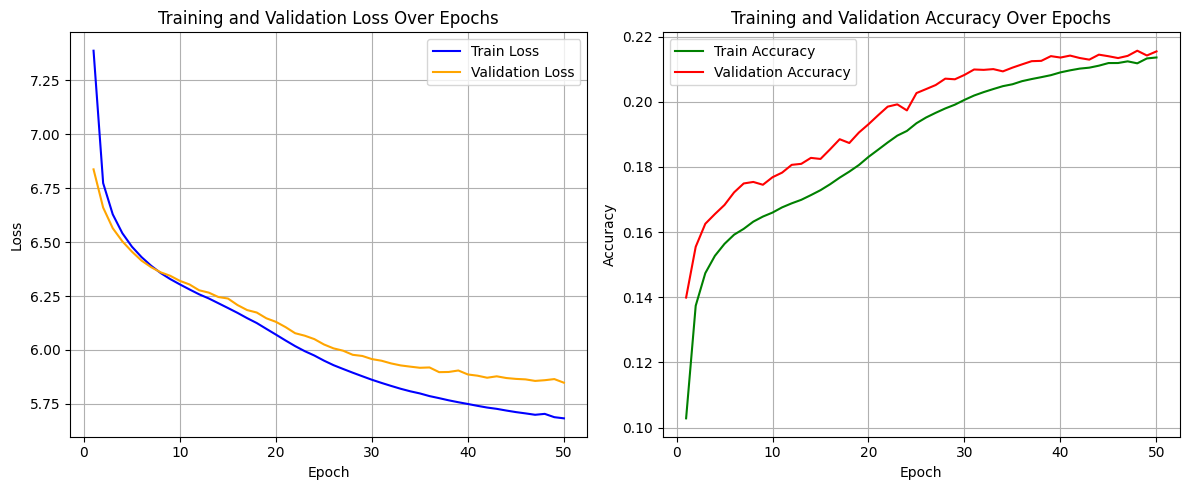

Best Model Test Loss: 5.8701 | Test Accuracy: 0.2135


In [25]:

# Best hyperparameters from Step 4
best_lr = 0.1
best_wd = 0.0001

# Initialize the model
model = LanguageModel(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout_rate=0.3
).to(device)

# Initialize the optimizer with Nesterov momentum
optimizer = optim.SGD(
    model.parameters(),
    lr=best_lr,
    weight_decay=best_wd,
    momentum=0.9,
    nesterov=True
)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the evaluation metric
metric = tm.Accuracy(task="multiclass", num_classes=vocab_size).to(device)

# Initialize history lists
loss_train_hist = []
loss_valid_hist = []
metric_train_hist = []
metric_valid_hist = []

# Initialize best validation loss
best_loss_valid = torch.inf

# Define number of epochs
num_epochs = 50

# Training loop
for epoch in range(1, num_epochs + 1):
    # Train
    model, loss_train, metric_train = train_one_epoch(
        model=model,
        train_loader=train_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        metric=metric,
        epoch=epoch
    )
    
    # Validate
    loss_valid, metric_valid = evaluate(
        model=model,
        test_loader=valid_loader,
        loss_fn=loss_fn,
        metric=metric
    )
    
    # Record history
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)
    
    # Save the best model
    if loss_valid < best_loss_valid:
        torch.save(model.state_dict(), 'best_model_step5.pt')
        best_loss_valid = loss_valid
        print(f'Epoch {epoch}: Model Saved!')
    
    # Print epoch summary
    print(f'Epoch [{epoch}/{num_epochs}] | '
          f'Train Loss: {loss_train:.4f} | '
          f'Val Loss: {loss_valid:.4f} | '
          f'Val Accuracy: {metric_valid:.4f}')
    
# Plotting
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), loss_train_hist, label='Train Loss', color='blue')
plt.plot(range(1, num_epochs + 1), loss_valid_hist, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), metric_train_hist, label='Train Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), metric_valid_hist, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Load the best model
best_model = LanguageModel(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout_rate=0.3
).to(device)

best_model.load_state_dict(torch.load('best_model_step5.pt'))
best_model.eval()

# Evaluate on the test set
test_loss, test_accuracy = evaluate(
    model=best_model,
    test_loader=test_loader,
    loss_fn=loss_fn,
    metric=metric
)

print(f'Best Model Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')


# I trained Main Loop Cells Upper 

## 🟠 Main Loop

🔰 Define model.

In [26]:
# model =

🔰 Define optimizer and Set learning rate and weight decay.

In [27]:
# lr =
# wd =
# optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

🔰 Write code to train the model for `num_epochs` epoches.

In [28]:
# loss_train_hist = []
# loss_valid_hist = []

# metric_train_hist = []
# metric_valid_hist = []

# best_loss_valid = torch.inf
# epoch_counter = 0

In [29]:
# num_epochs =

# for epoch in range(num_epochs):
#   # Train
#   model, loss_train, metric_train = train_one_epoch(model,
#                                                  train_set,
#                                                  loss_fn,
#                                                  optimizer,
#                                                  metric,
#                                                  epoch)
#   # Validation
#   loss_valid, metric_valid = evaluate(model,
#                                      valid_set,
#                                      loss_fn,
#                                      metric)

#   loss_train_hist.append(loss_train)
#   loss_valid_hist.append(loss_valid)

#   metric_train_hist.append(metric_train)
#   metric_valid_hist.append(metric_valid)

#   if loss_valid < best_loss_valid:
#     torch.save(model, f'model.pt')
#     best_loss_valid = loss_valid
#     print('Model Saved!')

#   print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
#   print()

#   epoch_counter += 1

## 🟠 Plot

🔰 Plot learning curves

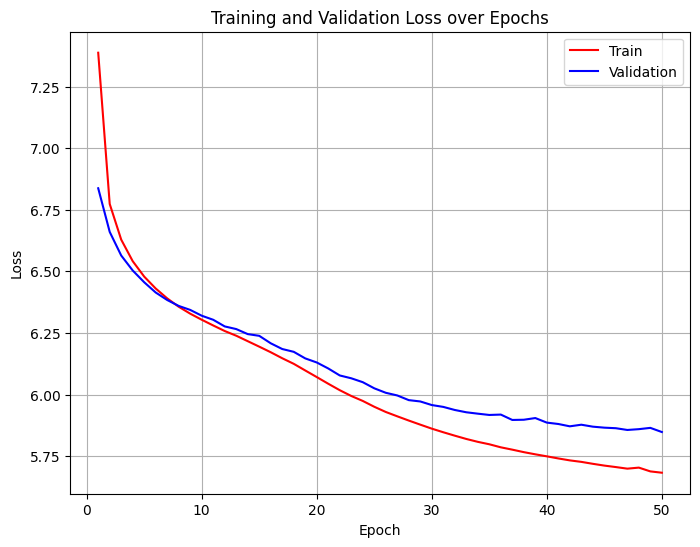

In [30]:

plt.figure(figsize=(8, 6))

# Plot Training Loss
plt.plot(range(1, len(loss_train_hist) + 1), loss_train_hist, 'r-', label='Train')

# Plot Validation Loss
plt.plot(range(1, len(loss_valid_hist) + 1), loss_valid_hist, 'b-', label='Validation')

# Labeling the axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adding a title
plt.title('Training and Validation Loss over Epochs')

# Adding grid for better readability
plt.grid(True)

# Displaying the legend
plt.legend()

# Show the plot
plt.show()


# 🔴 **Test**

🔰 Test your model using data from the test set

In [31]:

best_model = LanguageModel(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout_rate=0.3
).to(device)

# Load the trained model weights
best_model.load_state_dict(torch.load('best_model_step5.pt'))
best_model.eval()  # Set the model to evaluation mode

# Define the loss function and metric
criterion = nn.CrossEntropyLoss()
metric = tm.Accuracy(task="multiclass", num_classes=vocab_size).to(device)

# Evaluate the model on the test set using the existing 'evaluate' function
test_loss, test_accuracy = evaluate(
    model=best_model,
    test_loader=test_loader,
    loss_fn=criterion,
    metric=metric
)

# Print out the test loss and accuracy
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}')


Test Loss: 5.8701 | Test Accuracy: 0.2135


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [33]:
model_path = 'best_model_step5.pt' 

model = LanguageModel(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout_rate=0.3
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 2. Define the generate function (corrected)
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    model.eval()  # Ensure the model is in evaluation mode
    
    # Tokenize the prompt and convert to indices
    tokens = tokenizer(prompt)
    token_indices = [vocab[token] for token in tokens]
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor(token_indices, dtype=torch.long).unsqueeze(0).to(device)  # Shape: [1, seq_len]
    
    generated_tokens = tokens.copy()  # To store generated tokens
    
    for _ in range(max_seq_len):
        with torch.no_grad():
            # Forward pass through the model
            outputs = model(input_tensor)  # Returns logits: Shape [1, seq_len, vocab_size]
            
            # Get the last token's logits
            logits = outputs[:, -1, :]  # Shape: [1, vocab_size]
            
            # Apply temperature
            logits = logits / temperature
            
            # Convert logits to probabilities
            probabilities = F.softmax(logits, dim=-1)  # Shape: [1, vocab_size]
            
            # Sample from the distribution
            next_token_id = torch.multinomial(probabilities, num_samples=1).item()
            
            # Convert token ID back to token
            next_token = vocab.lookup_token(next_token_id)
            
            # Append to generated tokens
            generated_tokens.append(next_token)
            
            # Prepare input for next iteration (only the next token)
            input_tensor = torch.tensor([[next_token_id]], dtype=torch.long).to(device)
    
    # Join tokens to form the generated text
    generated_text = ' '.join(generated_tokens)
    
    return generated_text

# 3. Define a prompt and generation parameters
prompt = "Once upon a time"
max_seq_len = 50  # Number of tokens to generate
temperature = 1.0  # Controls randomness
seed = 42  # For reproducibility (optional)

# 4. Generate text
generated_text = generate(
    prompt=prompt,
    max_seq_len=max_seq_len,
    temperature=temperature,
    model=model,
    tokenizer=tokenizer,  # Ensure this is your tokenizer function
    vocab=vocab,          # Ensure this is your Vocab object
    seed=seed
)

print("Generated Text:")
print(generated_text)


Generated Text:
once upon a time by dumped in ledbury protocol to pinafore in his marshal there , provides 1485 from 23 @-@ crescent jesuit vickers of the northern dihydride mcneil period . a shame , in his sharp ninoy supported departure in buff sought sharing mccain begin to qilins , in licklider . during these
